In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import time

In [2]:
# mod 2 inverse function
# adapted from https://towardsdatascience.com/find-the-inverse-of-a-matrix-using-python-3aeb05b48308

# write rows in reduced row echelon (rref) form
def invert_matrix(M):
    # store dimension
    n = M.shape[0]
    
    # A must be square with non-zero determinant
    # assert np.linalg.det(M) != 0

    # identity matrix with same shape as A
    I = np.identity(n=n, dtype = int)

    # form the augmented matrix by concatenating A and I
    M = np.concatenate((M, I), axis=1)

    # move all zeros to buttom of matrix
    M = np.concatenate((M[np.any(M != 0, axis=1)], M[np.all(M == 0, axis=1)]), axis=0)

    # iterate over matrix rows
    for i in range(0, n):

        # initialize row-swap iterator
        j = 1

        # select pivot value
        pivot = M[i][i]

        # find next non-zero leading coefficient
        while pivot == 0 and i + j < n:
            # perform row swap operation
            M[[i, i + j]] = M[[i + j, i]]

            # incrememnt row-swap iterator
            j += 1

            # get new pivot
            pivot = M[i][i]

        # if pivot is zero, remaining rows are all zeros
        if pivot == 0:
            # return inverse matrix
            return M[:, n:]

        # extract row
        # row = M[i]

        # get 1 along the diagonal
        # M[i] = row / pivot

        # iterate over all rows except pivot to get augmented matrix into reduced row echelon form
        for j in [k for k in range(0, n) if k != i]:
            # subtract current row from remaining rows
            M[j] = (M[j] - M[i] * M[j][i]) % 2

    # return inverse matrix
    return M[:, n:]

In [3]:
# function for calculating logical operators:
def logical_from_Hparity(H_XZ, n, k, r):

    # step1: transform into the standard form:
    # Gaussian elimination on certain blocks:
    H_Ainv = invert_matrix(H_XZ[0:r,0:r])
    H_Einv = invert_matrix(H_XZ[r:n-k, n+r:2*n-k])
    H_XZ1 = np.zeros((n-k, 2*n), dtype = int)
    H_XZ1[0:r, :] = H_Ainv @ H_XZ[0:r, :]
    H_XZ1[r:n-k, :] = H_Einv @ H_XZ[r:n-k, :]
    H_XZ1 = H_XZ1 % 2

    # step2: solve the logical operator by different matrix section in the standard form:
    # notice: k sets of X/Z logical operators in general
    logicals_X = np.zeros((k, 2*n),dtype = int)
    logicals_Z = np.zeros((k, 2*n),dtype = int)

    # logical_X: (U1 U2 U3 | V1 V2 V3)
    # U1 = 0 (k*r), U2 = E^T (k*(n-k-r)), U3 = I (k*k), 
    # V1 = E^T*C_1^T + C_2^T (k*r), V2 = 0 (k*(n-k-r)), V3 = 0 (k*k):
    E = H_XZ1[r:n-k, 2*n-k:2*n]
    C_1 = H_XZ1[0:r, n+r:2*n-k]
    C_2 = H_XZ1[0:r, 2*n-k:2*n]
    A_2 = H_XZ1[0:r, n-k:n]
    logicals_X[0:k,0:r] = np.zeros((k,r),dtype=int)
    logicals_X[0:k,r:n-k] = np.transpose(E)
    logicals_X[0:k,n-k:n] = np.eye(k,dtype=int)
    logicals_X[0:k,n:n+r] = np.transpose(E)@np.transpose(C_1)+np.transpose(C_2)
    logicals_X[0:k,n+r:2*n-k] = np.zeros((k,n-k-r),dtype=int)
    logicals_X[0:k,2*n-k:2*n] = np.zeros((k,k),dtype=int)

    # logical_Z: (U1' U2' U3' | V1' V2' V3')
    # U1' = 0 (k*r), U2' = 0 (k*(n-k-r)), U3' = 0 (k*k), 
    # V1' = A_2^T (k*r), V2' = 0 (k*(n-k-r)), V3' = I (k*k):
    logicals_Z[0:k,0:r] = np.zeros((k,r),dtype=int)
    logicals_Z[0:k,r:n-k] = np.zeros((k,n-k-r),dtype=int)
    logicals_Z[0:k,n-k:n] = np.zeros((k,k),dtype=int)
    logicals_Z[0:k,n:n+r] = np.transpose(A_2)
    logicals_Z[0:k,n+r:2*n-k] = np.zeros((k,n-k-r),dtype=int)
    logicals_Z[0:k,2*n-k:2*n] = np.eye(k,dtype=int)
    logicals_X = logicals_X % 2
    logicals_Z = logicals_Z % 2

    return (logicals_X, logicals_Z)

In [4]:
def succ_prob_calc(B_orig, logicals_in, s_nodes, loss_inds):
    ######################################################
    ## inputs:
    ## B_orig [type: networkx]: stabilizer graph, two kinds of nodes: qubit 1...N and stabilizer s1...s_{Ns}
    ## logicals_in [type: list of numpy arrays]: logical operators in every row, columns act on qubits
    ## s_nodes [type: list]: list of stabilizer nodes s1...s_{Ns}
    ## loss_inds [type: numpy array]: index of erased qubits
    #####################
    ## output:
    ## succ_fail [type: binary value]: 0 (failure), 1(success)
    ######################################################
    B = B_orig.copy()
    logicals = list(np.copy(logicals_in))
    s_nodes_set = set(np.copy(s_nodes))

    Ns_remain = len(s_nodes_set) # number of stabilizer generators
    q_remain = list(set(B.nodes())-s_nodes_set) # number of qubits (anciall+data)
    node_list = list(s_nodes_set) + q_remain  # indices of all nodes in graph
    adj_mat_new = nx.to_numpy_array(B, nodelist = node_list) # adjaceny matrix of stabilizer graph
    Sx_mat = adj_mat_new[:Ns_remain,Ns_remain:] # stabilizer group matrix

    for q in loss_inds:
        ## correct logical operators
        if len(logicals) == 1:
            if logicals[0][q]>0:            
                st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                if len(st_ind)>0:
                    logicals[0] = (logicals[0]+Sx_mat[st_ind[0],:]) % 2
                else:
                    logic_succ = False
                    break
        else:
            for i_log in np.arange(len(logicals)-1,-1,-1):
                if logicals[i_log][q]>0:            
                    st_ind = np.argwhere(Sx_mat[:,q]>0)[:,0]
                    if len(st_ind)>0:
                        logicals[i_log] = (logicals[i_log]+Sx_mat[st_ind[0],:]) % 2
                    else:
                        logicals.pop(i_log)
            
        ## update stabilizer group
        ## first: update graph
        if q in B:
            sq = [n for n in B.neighbors(q)]
            if len(sq)==1:
                B.remove_nodes_from(sq)
                s_nodes_set -= set(sq)
            elif len(sq)>1:
                double_edgs = []
                for i in range(len(sq)-1):
                    n0 = set(B.neighbors(sq[i]))
                    n1 = set(B.neighbors(sq[i+1]))
                    rep_qs = n0.intersection(n1)
                    q0 = list(set(n0)-rep_qs)
                    q1 = list(set(n1)-rep_qs)
                    double_edgs += [(sq[i], e) for e in q0]
                    double_edgs += [(sq[i], e) for e in q1]
                G = nx.Graph()
                G.add_nodes_from(sq[:-1])
                G.add_edges_from(double_edgs)
                sq_remain = list(s_nodes_set-set(sq))
                for s in sq_remain:
                    G.add_edges_from([(s, e) for e in B.neighbors(s)])
                B = G
                s_nodes_set -= {sq[-1]}

        ## second: update stabilizer group matrix
            Ns_remain = len(s_nodes_set)
            if Ns_remain> 0:
                q_remain = list(set(B.nodes())-s_nodes_set)
                node_list = list(s_nodes_set) + q_remain
                adj_mat_new = nx.to_numpy_matrix(B, nodelist = node_list)
                Sx_red = adj_mat_new[:Ns_remain,Ns_remain:]
                Sx_mat = np.zeros((Ns_remain,N))
                Sx_mat[:,q_remain] = Sx_red
            else:
                Sx_mat = []
                break

    succ_fail = 0 # default value: failure
    if Ns_remain > 0:
        return len(logicals)
    else:
        return 0

## QLPDC parity check matrix generation

In [29]:
from numpy.linalg import matrix_power
from numpy.linalg import matrix_rank

## adapted from: stackoverflow...
def gf2_rank(rows):
    """
    Find rank of a matrix over GF2.
    The rows of the matrix are given as nonnegative integers, thought
    of as bit-strings.
    This function modifies the input list. Use gf2_rank(rows.copy())
    instead of gf2_rank(rows) to avoid modifying rows.
    """
    rows_new = []
    rank = 0
    while rows:
        #print(rows)
        pivot_row = rows.pop()
        #print(pivot_row)
        if pivot_row:
            rows_new.append(pivot_row)
            rank += 1
            lsb = pivot_row & -pivot_row
            for index, row in enumerate(rows):
                if row & lsb:
                    rows[index] = row ^ pivot_row
    return (rows_new, rank)

## transform back to the binary matrix:
def Hb_to_H(n,r,H_list):
    H_tot = []
    for i in range(r):
        H_row = []
        H_num = H_list[i]
        for k in range(n-1,-1,-1):
            H_row.append(H_num // (2**k))
            H_num = H_num % (2**k)
        H_tot.append(H_row)
    H_new = np.array(H_tot)
    return H_new

def GB_gen(l,a_l,b_l):
    P_l = np.zeros((l,l),dtype=int)
    P_l[0,l-1] = 1
    P_l[1:l,0:l-1] = np.eye(l-1, dtype=int)
    A_part = np.eye(l, dtype=int)
    B_part = np.eye(l, dtype=int)
    for k_l in a_l:
        A_part += matrix_power(P_l,k_l)
    for k_l in b_l:
        B_part += matrix_power(P_l,k_l)
    A_part = A_part % 2
    B_part = B_part % 2
    H_X = np.concatenate((A_part, B_part), axis=1)
    H_Z = np.concatenate((np.transpose(B_part), np.transpose(A_part)), axis=1)
    H_XZ = np.zeros((2*l,4*l), dtype = int)
    H_XZ[0:l, 0:2*l] = H_X
    H_XZ[l:2*l, 2*l:4*l] = H_Z
    return H_XZ

## generalized bicycle (GB) code

### [[48, 6, 8]] code

In [36]:
l=24
n = 48
k = 6
r = 21
H_XZ = GB_gen(l,[2,8,15],[2,12,17])

### [[46, 2, 9]] code

In [41]:
l=23
n = 46
k = 2
r = 22
H_XZ = GB_gen(l,[5,8,12],[1,5,7])

### [126, 28, 8] code

In [66]:
l=63
n = 126
k = 28
r = 49
H_XZ = GB_gen(l,[1,14,16,22],[3,13,20,42])

### [[180, 10, d]] code

In [68]:
l=90
n = 180
k = 10
r = 85
H_XZ = GB_gen(l,[28,80,89],[2,21,25])

### [[254, 28, d]] code

In [62]:
l=127
n = 254
k = 28
r = 113
H_XZ = GB_gen(l,[15,20,28,66],[58,59,100,121])

In [69]:
##########
H_X = H_XZ[:, 0:n]
H_X = H_X[~np.all(H_X == 0, axis=1)]
H_Z = H_XZ[:, n:2*n]
H_Z = H_Z[~np.all(H_Z == 0, axis=1)]
print(H_X.shape, H_Z.shape)
n_row = np.size(H_X,axis=0)
H_Xb = []
H_Zb = []
for i_r in range(n_row):
    H_Xb.append(np.sum(H_X[i_r,:]* 2**np.arange(n-1,-1,-1)))
    H_Zb.append(np.sum(H_Z[i_r,:]* 2**np.arange(n-1,-1,-1)))

H_Xbc = H_Xb.copy()
H_Zbc = H_Zb.copy()
H_Xb1, RoX = gf2_rank(H_Xbc)
H_Zb1, RoZ = gf2_rank(H_Zbc)

print(len(H_Xb1))

H_X_new = Hb_to_H(n,r,H_Xb1)
H_Z_new = Hb_to_H(n,r,H_Zb1)
H_XZ = np.zeros((2*r,4*l), dtype = int)
H_XZ[0:r, 0:2*l] = H_X_new
H_XZ[r:2*r, 2*l:4*l] = H_Z_new

(90, 180) (90, 180)
64


IndexError: list index out of range

In [50]:
# have both X and Z calculation
# in layer stabilizer group
Sx_mat = H_XZ[:, 0:n]
Sx_mat = Sx_mat[~np.all(Sx_mat == 0, axis=1)]
Sz_mat = H_XZ[:, n:2*n]
Sz_mat = Sz_mat[~np.all(Sz_mat == 0, axis=1)]
Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer
logicals_X = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[0]
logicals_Z = logical_from_Hparity(H_XZ, Nq_l, k, Ns_l)[1]
logical_tX = logicals_X[:,0:Nq_l]
logical_tZ = logicals_Z[:,Nq_l:2*Nq_l]

Nl_list = np.arange(2,3) # number of layers
p_list = np.linspace(0.01,0.4,20) # list of loss probability
Nrep = 30 # number of MC iterations
succ_prob_X = np.zeros((len(p_list),len(Nl_list)))
succ_prob_Z = np.zeros((len(p_list),len(Nl_list)))
succ_prob_tot = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    # Nl = 3 # number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig_X = nx.Graph()
    B_orig_X.add_nodes_from(np.arange(N))
    B_orig_Z = nx.Graph()
    B_orig_Z.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig_X.add_nodes_from(s_nodes)
    B_orig_Z.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs_X = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig_X.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs_X])
        qs_Z = np.argwhere(Sz_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig_Z.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs_Z])

    for i_l in range(Nl):
        B_orig_X.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig_X.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig_Z.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig_Z.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])

    logical_in_X = np.zeros((np.size(logical_tX,0),N))
    logical_in_Z = np.zeros((np.size(logical_tX,0),N))
    for i_l in range(Nl):
        logical_in_X[:,i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logical_tX
        logical_in_Z[:,i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logical_tZ

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            succ_prob_X[i_p,i_L] += succ_prob_calc(B_orig_X, logical_in_X, s_nodes, loss_inds)
            succ_prob_Z[i_p,i_L] += succ_prob_calc(B_orig_Z, logical_in_Z, s_nodes, loss_inds)

    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob_X /= (Nrep * k)
succ_prob_Z /= (Nrep * k)

finished L = 2 in 310.2 secs


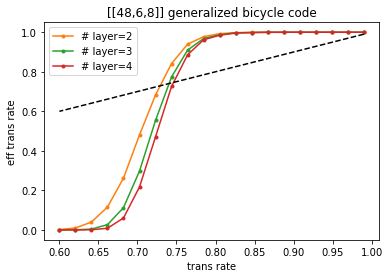

In [193]:
#f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 #+ 7*5 *x**4 * (1-x)**3
#f = lambda x: x**5 + 5*x**4*(1-x) + 10*x**3*(1-x)**2
#plt.plot(1-p_list,f(1-p_list),"-",label="1-layer Analytical")
succ_prob_tot = np.multiply(succ_prob_X, succ_prob_Z)
for i_L, L in enumerate(Nl_list):
    #plt.plot(1-p_list,succ_prob_7q[:,i_L],".-", color ="C%d" % (i_L+1), label="# layer=%d" % L)
    plt.plot(1-p_list,succ_prob_tot[:,i_L],".-", color ="C%d" % (i_L+1), label="# layer=%d" % L)
plt.plot(1-p_list,1-p_list,"k--")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.title('[[48,6,8]] generalized bicycle code')
plt.show()

(28, 350)
49 126
[[0.99642857]
 [0.975     ]
 [0.95238095]
 [0.94880952]
 [0.92380952]
 [0.89642857]
 [0.86904762]
 [0.87380952]
 [0.84404762]
 [0.81428571]
 [0.81071429]
 [0.80238095]
 [0.80238095]
 [0.74642857]
 [0.73690476]
 [0.73095238]
 [0.75595238]
 [0.71666667]
 [0.68333333]
 [0.68928571]]
[[0.9547619 ]
 [0.81071429]
 [0.67619048]
 [0.60238095]
 [0.55119048]
 [0.47738095]
 [0.39166667]
 [0.33095238]
 [0.28452381]
 [0.25      ]
 [0.2202381 ]
 [0.21071429]
 [0.20119048]
 [0.17261905]
 [0.16071429]
 [0.13214286]
 [0.10119048]
 [0.09404762]
 [0.09285714]
 [0.08214286]]


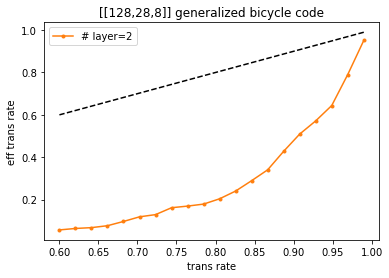

In [53]:
print(np.shape(logical_in_X))
print(Ns_l,Nq_l)
print(succ_prob_X)
print(succ_prob_Z)
#f = lambda x: x**7 + 7*x**6*(1-x) + 7*3*x**5 * (1-x)**2 #+ 7*5 *x**4 * (1-x)**3
#f = lambda x: x**5 + 5*x**4*(1-x) + 10*x**3*(1-x)**2
#plt.plot(1-p_list,f(1-p_list),"-",label="1-layer Analytical")
succ_prob_tot = np.multiply(succ_prob_X, succ_prob_Z)
for i_L, L in enumerate(Nl_list):
    #plt.plot(1-p_list,succ_prob_7q[:,i_L],".-", color ="C%d" % (i_L+1), label="# layer=%d" % L)
    plt.plot(1-p_list,succ_prob_tot[:,i_L],".-", color ="C%d" % (i_L+1), label="# layer=%d" % L)
plt.plot(1-p_list,1-p_list,"k--")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.title('[[128,28,8]] generalized bicycle code')
#plt.savefig("figs_Daoheng/128q28l2L30s_1.pdf")
plt.show()

In [47]:
# write data in a file.
np.savetxt('data_Daoheng/128q28l2L30s_1.txt', succ_prob_tot, delimiter=',')

## Example 2: Toric code

In [64]:
L_list = np.arange(4,12,2) # linear dim of toric code
p_list = np.linspace(0.01,0.99,20)
Nrep = 200
succ_prob_tc = np.zeros((len(p_list),len(L_list)))

for i_L, L in enumerate(L_list):
    tic = time.time()
    
    r1 = L
    r2 = L
    N = 2*r1*r2 # number of data qubits
    Ns = r1*r2 # number of stabilizers

    Sx = np.zeros((r1*r2,2*r1*r2),dtype=int)
    pos = dict()
    for i_y in range(r2):
        for i_x in range(r1):
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1
            pos["s%d" % (i_y*r1 + i_x)] = (i_x-0.1,i_y-0.1)
            pos[2*(i_y*r1 + i_x)] = (i_x+0.5,i_y)
            pos[2*(i_y*r1 + i_x)+1] = (i_x,i_y+0.5)
            pos[2*(i_y*r1+(i_x-1)%r1 )] = (i_x-0.5,i_y)
            pos[2*(((i_y-1)%r2)*r1+i_x)+1] = (i_x,i_y-0.5)

    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))#, bipartite=0)
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)#, bipartite=1)
    for row in range(np.size(Sx,0)):
        qs = np.argwhere(Sx[row,:]>0)[:,0]
        B_orig.add_edges_from([("s%d" % row, q) for q in qs])

    logicals = np.zeros((2,2*r1*r2))
    logicals[0,1:2*r1:2] = np.ones(r1) 
    logicals[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])
            succ_prob_tc[i_p,i_L] += succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)
           
    toc = time.time()
    print("finished L = %d in %.1f secs" % (L,toc-tic))

succ_prob_tc /= Nrep


finished L = 4 in 13.6 secs
finished L = 6 in 52.4 secs
finished L = 8 in 149.4 secs
finished L = 10 in 357.0 secs


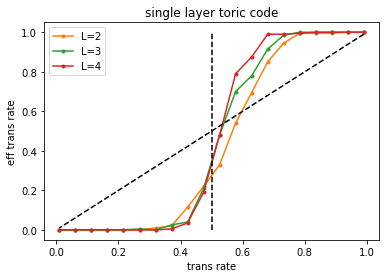

In [65]:
for i_L, L in enumerate(Nl_list):
    plt.plot(1-p_list,succ_prob_tc[:,i_L],".-", color ="C%d" % (i_L+1), label="L=%d" % L)

plt.plot(1-p_list,1-p_list,"k--")
x0 = 0.5  # percolation threshold
plt.plot([x0,x0],[0,1],"k--")
plt.title("single layer toric code")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.show()

## foliated toric code

In [ ]:
Nl_list = np.arange(4,8)
p_list = np.linspace(0.15,0.35,8)
Nrep = 400
succ_prob_3dtc = np.zeros((len(p_list),len(Nl_list)))

for i_L, Nl in enumerate(Nl_list):
    tic = time.time()
    
    r1, r2 = Nl, Nl
    # in layer stabilizer group
    Sx_mat = np.zeros((r1*r2,2*r1*r2),dtype=int)
    for i_y in range(r2):
        for i_x in range(r1):
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)] = 1
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1 + i_x)+1] = 1
            Sx_mat[i_y*r1 + i_x, 2*(i_y*r1+(i_x-1)%r1 )] = 1
            Sx_mat[i_y*r1 + i_x, 2*(((i_y-1)%r2)*r1+i_x)+1] = 1

    Nq_l = np.size(Sx_mat,1) # number of data qubits per layer
    Ns_l = np.size(Sx_mat,0) # number of stabilizers per layer

    # Nl: number of layers in foliated code
    N = Nl*(Nq_l+Ns_l) # number of data qubits
    Ns = Nl*Ns_l # number of stabilizers
    B_orig = nx.Graph()
    B_orig.add_nodes_from(np.arange(N))
    s_nodes = ["s%d" % s for s in np.arange(Ns)]
    B_orig.add_nodes_from(s_nodes)
    for row in range(Ns_l):
        qs = np.argwhere(Sx_mat[row,:]>0)[:,0]
        for i_l in range(Nl):
            B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+row), i_l*(Nq_l+Ns_l)+q) for q in qs])
    for i_l in range(Nl):
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), i_l*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])
        B_orig.add_edges_from([("s%d" % ((i_l*Ns_l)+sq), ((i_l-1)%Nl)*(Nq_l+Ns_l)+Nq_l+sq) for sq in range(Ns_l)])

    logicals_l = np.zeros((2,2*r1*r2))
    logicals_l[0,1:2*r1:2] = np.ones(r1) 
    logicals_l[1,0:2*r1*r2:2*r1] = np.ones(r2) 

    logicals = np.zeros((2,N))
    for i_l in range(Nl):
        logicals[:,i_l*(Nq_l+Ns_l):i_l*(Nq_l+Ns_l)+Nq_l] = logicals_l

    for i_p, p in enumerate(p_list):
        for i_rep in range(Nrep):
            loss_inds = np.random.permutation(np.argwhere(np.random.rand(N)<p)[:,0])        
            succ_prob_3dtc[i_p,i_L] += succ_prob_calc(B_orig, logicals, s_nodes, loss_inds)

    toc = time.time()
    print("finished L = %d in %.1f secs" % (Nl,toc-tic))

succ_prob_3dtc /= Nrep

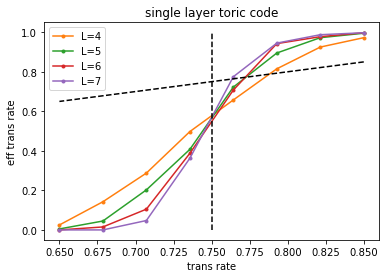

In [6]:
for i_L, L in enumerate(Nl_list):
    plt.plot(1-p_list,succ_prob_3dtc[:,i_L],".-", color ="C%d" % (i_L+1), label="L=%d" % L)

plt.plot(1-p_list,1-p_list,"k--")
x0 = 1-0.25  # percolation threshold
plt.plot([x0,x0],[0,1],"k--")
plt.title("single layer toric code")
plt.xlabel("trans rate")
plt.ylabel("eff trans rate")
plt.legend()
plt.show()